In [1]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import time
import math

In [2]:
latitude=37.983810 
longitude=23.727539
surface_tilt=0 
surface_azimuth=180
startyear=None
endyear=None
freq='h'

In [3]:
def days_between_dates(dt1, dt2):
    date_format = "%Y-%m-%d %H:%M:%S+00:00"
    a = time.mktime(time.strptime(dt1, date_format))
    b = time.mktime(time.strptime(dt2, date_format))
    delta = abs(b - a)
    return delta / (60 * 60 * 24)  # Convert seconds to days

data_load = pd.read_csv(fr'C:\test\load_data1.csv', parse_dates=True)
data_load.set_index(['Datetime'], inplace=True)
start=data_load.index[0]
end=data_load.index[-1]
num_days = days_between_dates(start, end)
num_years = math.ceil(num_days / 365)  # Assuming a year has 365 days

print(num_years)

6


In [137]:
tmy=pvlib.iotools.get_pvgis_tmy(latitude, 
                            longitude, 
                            outputformat='csv', 
                            usehorizon=True, 
                            userhorizon=None, 
                            startyear=startyear, 
                            endyear=endyear, 
                            map_variables=True, 
                            url='https://re.jrc.ec.europa.eu/api/v5_2/', 
                            timeout=30)[0]


In [138]:
tmy.columns

Index(['temp_air', 'relative_humidity', 'ghi', 'dni', 'dhi', 'IR(h)',
       'wind_speed', 'wind_direction', 'pressure'],
      dtype='object')

In [139]:
def extend_tmy_data(df, num_years):
    extended_dfs = []
    for year_offset in range(int(num_years)):
        extended_dfs.append(df.copy())
    extended_data = pd.concat(extended_dfs, ignore_index=True)
    return extended_data

In [140]:
num_years = num_years
extended_tmy_data = extend_tmy_data(tmy, num_years)
extended_tmy_data.index=pd.date_range(start=start, periods=len(extended_tmy_data), freq=freq)
extended_tmy_data_new=extended_tmy_data[start:end]
extended_tmy_data_new

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
2014-12-31 23:00:00+00:00,7.63,85.29,0.0,-0.0,0.0,330.85,5.39,341.0,100604.0
2015-01-01 00:00:00+00:00,7.53,85.56,0.0,-0.0,0.0,329.04,5.08,345.0,100564.0
2015-01-01 01:00:00+00:00,7.44,85.83,0.0,-0.0,0.0,327.23,4.77,342.0,100525.0
2015-01-01 02:00:00+00:00,7.34,86.10,0.0,-0.0,0.0,325.43,4.46,347.0,100455.0
2015-01-01 03:00:00+00:00,7.24,86.37,0.0,-0.0,0.0,323.62,4.14,350.0,100406.0
...,...,...,...,...,...,...,...,...,...
2020-09-30 19:00:00+00:00,20.94,87.65,0.0,-0.0,0.0,358.00,2.21,190.0,100347.0
2020-09-30 20:00:00+00:00,20.69,89.90,0.0,-0.0,0.0,355.80,2.21,199.0,100307.0
2020-09-30 21:00:00+00:00,20.46,92.00,0.0,-0.0,0.0,352.40,2.21,201.0,100277.0
2020-09-30 22:00:00+00:00,20.00,94.10,0.0,-0.0,0.0,350.40,1.93,208.0,100307.0


In [141]:
# extended_tmy_data_new.to_csv('pvgis_tmy.csv', index=True)

### **System modelling**

In [142]:
module_name = 'Canadian_Solar_CS5P_220M___2009_'
inverter_name = 'Power_Electronics__FS3000CU15__690V_' #'ABB__PVS980_58_2000kVA_K__660V_' #'ABB__ULTRA_1100_TL_OUTD_2_US_690_x_y_z__690V_'
location=Location(latitude, longitude, tz='Europe/Athens', altitude=100)

In [143]:
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod') 
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules[module_name]
inverter = sapm_inverters[inverter_name]
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

In [144]:
system=PVSystem(surface_tilt=surface_tilt, surface_azimuth=surface_azimuth,
                module_parameters=module, inverter_parameters=inverter,
                temperature_model_parameters=temperature_model_parameters,
                modules_per_string=40, strings_per_inverter=250
                )
modelchain=ModelChain(system, location)

In [145]:
# data=pd.read_csv('pvgis_tmy.csv', index_col=0)
data=extended_tmy_data_new
data.index=pd.to_datetime(data.index)

In [146]:
modelchain.run_model(data)
solar_data=modelchain.results.ac
solar_data=pd.DataFrame(solar_data, columns=(['GR_solar_generation']))

solar_data.loc[solar_data['GR_solar_generation'] < 0, 'GR_solar_generation'] = 0
solar_data/=1000000
solar_data.to_csv('solar_data.csv', index_label=['Datetime'])

In [147]:
solar_data.head(20)
# solar_data
solar_data.describe()

,GR_solar_generation
count,50401.000000
mean,0.398951
std,0.571551
min,0.000000
25%,0.000000
50%,0.000000
75%,0.794069
max,1.879019


<Axes: >

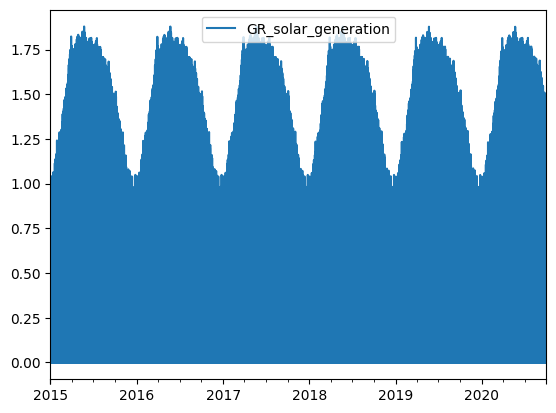

In [148]:
solar_data.plot()